# MLG_test

This notebook is a copy of TransientAsciiMetric.ipynb
This notebook demonstrates how to use the TransientAsciiMetric, which lets you use an ascii file to specify a lightcurve template, and then either calculate the likelihood of detecting a transient with that lightcurve or generate the actual lightcurve datapoints.

Running this notebook requires sympy to be installed. You can do it in the notebook using the command
~~~
! pip install sympy
~~~

Also, you need to make sure you have done the following before running the notebook:
~~~
cd sims_maf_contrib
eups declare sims_maf_contrib -r . -t $USER
setup sims_maf_contrib -t $USER -t sims
~~~

In [1]:
#    import maf packages
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import healpy as hp
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots

#from mafContrib import TransientAsciiMetric
from transientAsciiMetric_MLG import TransientAsciiMetric_MLG

First do some bookkeeping: connect to the opsim database and set up the output directory and resultsDb.

In [2]:
# Set the database and query
#runName = 'baseline2018a'
runName = 'astro-lsst-01_2021.db'
#This next command assumes you have downloaded baseline2018a.db into the tutorials directory in this repo.
#Change this path according to your datbase and where it is saved.
#opsdb = db.OpsimDatabase('../../tutorials/baseline2018a.db')
opsdb = db.OpsimDatabase('/home/docmaf/maf_local/astro-lsst-01_2021.db')

# Set the output directory
outDir = 'output_MLGtest'
resultsDb = db.ResultsDb(outDir)

Set up the transient ascii metric.  

Note that if `dataout` is True, the output at each slicePoint will be a dictionary of: 
 'lcNumber', 'expMJD', 'epoch', 'filter', 'lcMag', 'SNR', 'detected' (a flag indicating whether that lightcurve met the detection criteria). 
If `dataout` is False, the output at each slicePoint will be the likelihood of detecting a transient with this lightcurve.

In [3]:
#asciiLC = '2013ab_1.dat'
asciiLC = 'nugent_sn1a.dat'
transMetric = TransientAsciiMetric_MLG(asciiLC, surveyDuration=1, mjdCol='observationStartMJD', 
                                   detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                                   nPreT=0, preT=0, nFilters=1, filterT=None, nPerLC=0, peakOffset=+20,
                                   dataout=True)

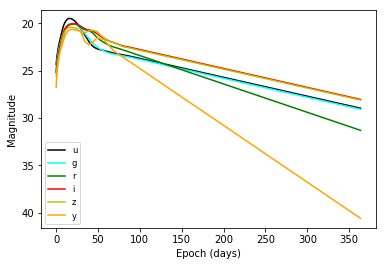

In [4]:
# Use the metric to generate a tightly sampled lightcurve, to illustrate what the lightcurve looks like.
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']
colors = {'u': 'k', 'g': 'cyan', 'r': 'g', 'i': 'r', 'z': 'y', 'y': 'orange'}
times = np.arange(0, transMetric.transDuration, 0.5)
lc = {}
for f in filterNames:
    lc[f] = transMetric.make_lightCurve(times, np.array([f]*len(times)))

plt.figure()
for f in filterNames:
    plt.plot(times, lc[f], color=colors[f], label=f)
#plt.ylim(23, 17)
plt.ylim([np.max(lc[f])+1,np.min(lc[f])-2])
plt.xlabel('Epoch (days)')
plt.ylabel('Magnitude')
plt.legend(fontsize='smaller', numpoints=1)

Set up the slicer and sql constraint, assign them all to a metricBundle.

In [5]:
# Slicer - we just want to look at what the full lightcurve output looks like, so choose a few representative points.
# With the UserPointsSlicer, you can set ra/dec for the places you want to evaluate.
# These ra/dec pairs are 1 DD field and 3 WFD fields.
ra = np.array([ 34.39339593,  73.58279239,  97.45622484,  94.92638699])
dec = np.array([ -5.09032894,   0.1873572 , -37.70921729, -18.53667436])
slicer = slicers.UserPointsSlicer(ra, dec)

# SQL constraint.
# select the of the survey that you want to run 
year = 0
sqlconstraint = 'night between %f and %f '% ((365.25*year,365.25*(year+1)))

lightcurve_metric = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, runName=runName)

In [6]:
# run the metric
bgroup = metricBundles.MetricBundleGroup({0: lightcurve_metric}, opsdb, 
                                         outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night between 0.000000 and 365.250000  for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 227026 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plot each of the lightcurves created by setting off a set of back-to-back transients at each of the slicePoints. Note that not every slicePoint is sampled equally in time, especially since we only looked at one year. 

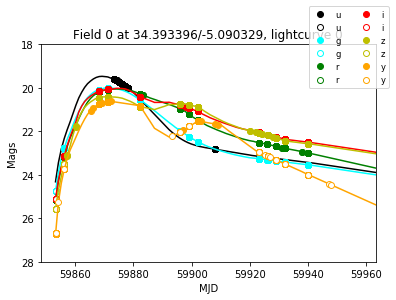

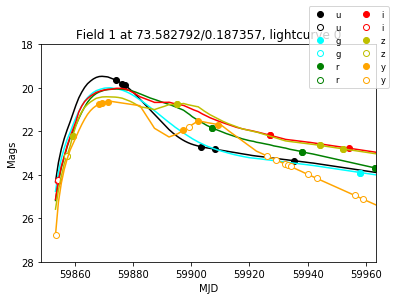

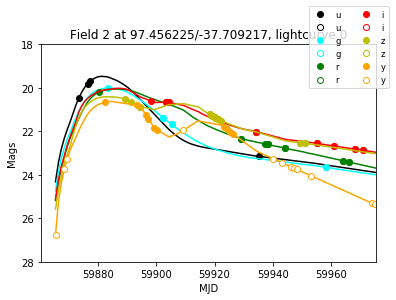

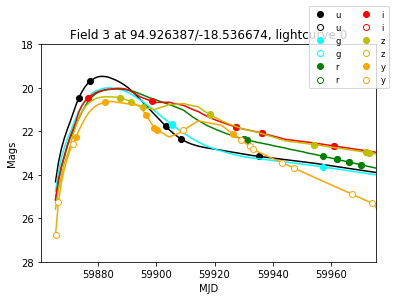

In [7]:
for i, data in enumerate(lightcurve_metric.metricValues):
    for lcN in np.unique(data['lcNumber']):
        match = np.where(data['lcNumber'] == lcN)
        plt.figure()
        epoch = data['epoch'][match]
        mjd = data['expMJD'][match]
        mags = data['lcMag'][match]
        filters = data['filter'][match]
        snr = data['SNR'][match]
        for f in filterNames:
            filtermatch = np.where(filters == f)
            plt.plot(times - epoch[0] + mjd[0], lc[f], color=colors[f])
            tx = np.where(snr[filtermatch] >= 5)[0]
            plt.plot(mjd[filtermatch][tx], mags[filtermatch][tx], 'o', color=colors[f], label=f)
            del tx
            tx = np.where(snr[filtermatch] < 5)[0]
            plt.plot(mjd[filtermatch][tx], mags[filtermatch][tx], 'o', mew=1,mec=colors[f],color='white', label=f)
        plt.ylim(plt.ylim()[::-1])
        plt.xlim(times[0] - epoch[0] + mjd[0] - 2, times[0] - epoch[0] + mjd[0] + 192)
        plt.legend(ncol = 2, loc = (.8,.8), numpoints=1, fontsize='smaller') 
        plt.xlabel('MJD')
        plt.ylabel('Mags')
        plt.ylim([28.0,18.0])
        plt.xlim([mjd[0]-5,mjd[0]+110])
        plt.title('Field %d at %f/%f, lightcurve %d' % (i, np.degrees(slicer.slicePoints['ra'][i]), 
                                                        np.degrees(slicer.slicePoints['dec'][i]), lcN))
        plt.show()

Now let's look at the metric, with dataout = False. In this case, it calculates the likelihood of detecting a transient at each slicePoint. We can also add some additional detection criteria.

In [ ]:
metric = TransientAsciiMetric(asciiLC, surveyDuration=0.9,mjdCol='observationStartMJD',
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                              nPreT=1, preT=365, nFilters=1, filterT=None, nPerLC=1, peakOffset=+20,
                              dataout=False)
slicer = slicers.HealpixSlicer(nside=16)
year = 0
#sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + 1))
sqlconstraint = 'night between 0 and 340'

plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
plotDict = {'colorMin': 0, 'colorMax': 1}

summaryMetrics = [metrics.MeanMetric(), metrics.RmsMetric()]

bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                    runName=runName, summaryMetrics=summaryMetrics,
                                    plotDict=plotDict, plotFuncs=plotFuncs)

In [ ]:
bundlegroup = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bundlegroup.runAll()

In [ ]:
bundlegroup.plotAll(closefigs=False)

In [ ]:
print (bundle.summaryValues)